# **Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"**

Nhóm 7:
1. 1712770 - Trương Thị Lệ Thanh - thanhtruong1712
2. 1712771 - Bùi Thái Tấn Thành - thanhtan0501
3. 1712778 - Thống A Thảo - thaothong21

Link thùng chứa Github của nhóm: [https://github.com/thanhtruong1712/DAMH_KHDLUD]

## **Mô tả bài toán**

### Giới thiệu bài toán

* **Tên cuộc thi**: [University of Liverpool - Ion Switching](https://www.kaggle.com/c/liverpool-ion-switching)
* **Mô tả**: 
  - Cuộc thi được diễn ra vào 25/2/2020 và kết thúc vào 26/5/2020 với tổng giải thưởng $25.000 với sự hợp tác của Đại học Liverpool. Trong cuộc thi này, chúng ta được cung cấp các tín hiệu điện tương ứng với dữ liệu kênh ion, và mục tiêu là tạo ra một thuật toán có thể tự động xác định số lượng kênh được mở tại mỗi thời điểm.
  - Kênh ion là các màng protein tạo lỗ có ở động vật và thực vật cho phép các ion đi qua lỗ kênh. Chúng mã hóa khả năng học tập và trí nhớ giúp chống lại nguy cơ nhiễm trùng và kích thích co cơ. Các kênh ion này có thể được ghi lại thông qua kỹ thuật kẹp dính mảnh màng(patch clamp) và được phân tích để suy ra một số đặc tính của bệnh 
* **Input**: Tập dữ liệu tín hiệu điện sinh lý
* **Output**: Dự đoán số lượng kênh ion được mở tại mỗi thời điểm.
* **Độ đo**: Ta có tập train gồm 5 triệu dòng, trong khi tập test gồm 2 triệu dòng. Mục tiêu của cuộc thi này là tối ưu hóa điểm số F1 trên 2 triệu dòng đó. Điểm F1 được định nghĩa là trung bình điều hòa (harmonic mean) giữa precision và recall.
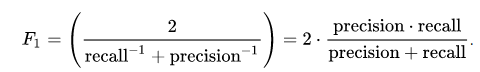

trong đó:
  - Precision được định nghĩa là tỉ lệ số điểm true positive trong số những điểm được phân loại là positive (TP + FP).
  - Recall được định nghĩa là tỉ lệ số điểm true positive trong số những điểm thực sự là positive (TP + FN).
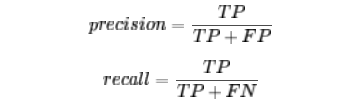



### Mô tả dữ liệu:
  - Dữ liệu được cung cấp khá đơn giản, chỉ chứa 3 cột
    - times: mốc thời gian được ghi lại
    - signal: giá trị tín hiệu điện(ampere) cho mỗi mốc thời gian, các giá trị này được đo ở tần số lấy mẫu là 10 kHz
    - open_channels: số kênh mở tương ứng tại mốc thời gian đó(chỉ được cung cấp cho tập train)
  - Files:
* **train.csv**: 
* **test.csv** :
* **sample_submission.csv**
<br>

## **Giải quyết bài toán**

### 1. Ý tưởng: 
* Trong đồ án này, nhóm tìm hiểu và cài đặt lại phương pháp đứng thứ [3](https://github.com/GillesVandewiele/Liverpool-Ion-Switching) trên private leaderboard cho bài toán University of Liverpool - Ion Switching.
* Tóm tắt các bước thực hiện:
  - Tiền xử lý dữ liệu 
  - Sử dụng mô hình Markov ẩn
  - Mở rộng mô hình Markov ẩn
  - Hậu xử lý dữ liệu


 ### 2. Lý do lựa chọn:

  - Solution ...

### 3. Cài đặt





#### Import các thư viện cần thiết


In [ ]:

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import scipy.optimize as opt
from sklearn.metrics import f1_score


#### Tiền xử lý

##### 1.
Chúng ta sử dụng phép biến đổi tuyến tính cho mỗi 

In [ ]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [ ]:
# The start of our batches (* 100_000)
BATCHES = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 65, 70])

# The data categories of our batches (5 of them have been identified in Chris Deotte 
# "One Feature Model notebook"). But we have noticed a 6th type in the test data.
CATEGORIES = np.array([1, 1, 2, 3, 5, 4, 2, 3, 4, 5, 6, 3, 4, 6, 2, 5, 4, 5, 6, 3, 6, 6])

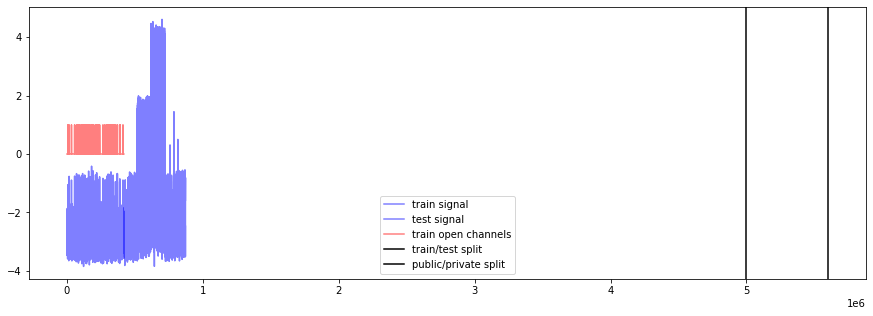

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train['signal'], label='train signal', c='b', alpha=0.5)
plt.plot(range(len(train), len(train) + len(test)), test['signal'], label='test signal', c='b', alpha=0.5)
plt.plot(train['open_channels'], c='r', label='train open channels', alpha=0.5)
plt.axvline(5_000_000, c='k', label='train/test split')
plt.axvline(5_600_000, c='k', label='public/private split')
plt.legend()
plt.show()

In [ ]:
for c in range(1, 6):
    # Take the training data corresponding to this category
    ix = np.where(CATEGORIES[:-11] == c)[0]
    starts = BATCHES[ix]
    ends = BATCHES[ix + 1]
    X = []
    y = []
    for start, end in zip(starts, ends):
        subsignal = train['signal'].values[start*100_000:end*100_000]
        subtarget = train['open_channels'].values[start*100_000:end*100_000]
        
        # Skip the anomalous part between 3.6M - 3.9M
        if start == 35:
            subsignal = list(subsignal[:100_000]) + list(subsignal[-100_000:])
            subtarget = list(subtarget[:100_000]) + list(subtarget[-100_000:])
        
        X.extend(subsignal)
        y.extend(subtarget)
    X = np.array(X)
    y = np.array(y)
    
    # Create a dataframe with our values, than groupby the open channel
    # values and take the mean
    df = pd.DataFrame(np.hstack((X.reshape(-1, 1),
                                 y.reshape(-1, 1))),
                      columns=['X', 'y'])
    means = df.groupby('y')[['X']].mean()
    X = means['X'].values
    y = means.index.values
    
    # Fit Linear Regression on the means.
    lr = LinearRegression()
    lr.fit(X.reshape(-1, 1), y)
    print(c, lr.intercept_, lr.coef_)

1 2.197759496904231 [0.8078022]


ValueError: ignored

In [ ]:
# As we tuned the entire pipeline during the competition, we also adjusted these
# values a little bit and checked the impact on our training F1 score. Below
# are our final values:
OFFSETS = [2.180783, 2.221318, 2.221318, 2.221318, 4.4288541, 2.221318]
SLOPE = 0.8107

signal = np.concatenate((train['signal'].values, test['signal'].values))
for i, (start, end) in enumerate(zip(BATCHES[:-1], BATCHES[1:])):
    c = CATEGORIES[i] - 1
    signal[start*100_000:end*100_000] = OFFSETS[c] + SLOPE * signal[start*100_000:end*100_000]

train['signal'] = signal[:5_000_000]
test['signal'] = signal[5_000_000:]

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train['signal'], label='train signal', c='b', alpha=0.5)
plt.plot(range(len(train), len(train) + len(test)), test['signal'], label='test signal', c='b', alpha=0.5)
plt.plot(train['open_channels'], c='r', label='train open channels', alpha=0.5)
plt.axvline(5_000_000, c='k', label='train/test split')
plt.axvline(5_600_000, c='k', label='public/private split')
plt.legend()
plt.show()

In [ ]:
# Let's check what our F1 score would be if we just round our signal values
good_ids = list(range(0, 3_600_000)) + list(range(3_900_000, 5_000_000))
f1_score(train['open_channels'].values[good_ids], 
         np.clip(np.round(train['signal'].values[good_ids]).astype(int), 0, 10), 
         average='macro')

In [ ]:
train.to_csv('train_1.csv', index=False)
test.to_csv('test_1.csv', index=False)

In [ ]:
# Use the result from previous notebook
train = pd.read_csv('train_1.csv')
test = pd.read_csv('test_1.csv')
predictions = pd.read_csv('Ys.csv', index_col=None, skiprows=1, header=None).values.flatten()

## Nhìn lại quá trình làm đồ án

Sau bao ngày vất vả làm đồ án thì bây giờ đã kết thúc. Bây giờ là lúc để ngồi uống coffee và tĩnh tâm nhìn lại quá trình làm.

- Mỗi thành viên: Đã gặp những khó khăn gì? (Hay mọi chuyện đều thuận lợi)
- Mỗi thành viên: Có học được gì hữu ích? (Hay không học được gì)
- Nhóm: Nếu có thêm thời gian thì sẽ làm gì?

Phần này có sao thì bạn nói vậy thôi, chứ không phải là viết
cho có, hoặc tự chế ra để nghe cho hay.

## Tài liệu tham khảo

Để hoàn thành đồ án này, nhóm bạn đã tham khảo những tài liệu nào?